## BIOMEDICAL QUESTION - ANSWERING SYSTEM

In [ ]:
! pip install transformers

IMPORTS

In [ ]:
# Imports
import pandas as pd
import json
import nltk
import tensorflow as tf
import transformers
import os
from transformers import AutoModel, AutoTokenizer, BertTokenizer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import warnings
warnings.filterwarnings('ignore')
import numpy as np
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import re
import string
import time

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# DATA INGESTION

Loading the files

In [ ]:
global_l = []
full_abstract = os.listdir('/content/drive/My Drive/BIOASQ/BioASQ-6b/train/Full-Abstract/')
appended_snippet = os.listdir('/content/drive/My Drive/BIOASQ/BioASQ-6b/train/Appended-Snippet/')
snippet = os.listdir('/content/drive/My Drive/BIOASQ/BioASQ-6b/train/Snippet-as-is/')
files = [full_abstract, appended_snippet, snippet]
for f in files:
    print(f)

['BioASQ-train-yesno.json', 'BioASQ-full-annotated.json', 'BioASQ-list-annotated.json']
['BioASQ-train-list-6b-snippet-2sent.json', 'BioASQ-train-factoid-6b-snippet-2sent.json', 'BioASQ-train-yesno-6b-snippet-2sent.json']
['BioASQ-train-yesno-6b-snippet.json', 'BioASQ-train-list-6b-snippet-annotated.json', 'BioASQ-train-factoid-6b-snippet-annotated.json']


Extracting data and structuring it to dataframe

In [ ]:
def extract_data(filename,global_l):
    with open(filename,"r") as f:
        data = f.read()
        data = json.loads(data)
        data = data["data"][0]
        for d in data["paragraphs"]:
            q_id = d["qas"][0]["id"]
            question = d["qas"][0]["question"]
            try:
                answer = d["qas"][0]["answers"][0]["text"]
            except:
                answer = d["qas"][0]["answers"]
            try:
                answer_start = d["qas"][0]["answers"][0]["answer_start"]
            except:
                answer_start = -1
            context = d["context"]
            global_l.append([q_id,question,answer,answer_start,context])
    return

In [ ]:
global_l = []
dirs = ["/content/drive/My Drive/BIOASQ/BioASQ-6b/train/Full-Abstract/",
        "/content/drive/My Drive/BIOASQ/BioASQ-6b/train/Appended-Snippet/",
        "/content/drive/My Drive/BIOASQ/BioASQ-6b/train/Snippet-as-is/"]

for dir in dirs:
    for file in os.listdir(dir):
        print(file)
        if "yesno" not in file:
            extract_data(dir+file,global_l)

BioASQ-train-yesno.json
BioASQ-full-annotated.json
BioASQ-list-annotated.json
BioASQ-train-list-6b-snippet-2sent.json
BioASQ-train-factoid-6b-snippet-2sent.json
BioASQ-train-yesno-6b-snippet-2sent.json
BioASQ-train-yesno-6b-snippet.json
BioASQ-train-list-6b-snippet-annotated.json
BioASQ-train-factoid-6b-snippet-annotated.json


In [ ]:
# Naming the columns, shuffling rows
df = pd.DataFrame(global_l, columns =['q_id', 'question', 'answer','answer_start','context'])
df = df.sample(frac=1).reset_index(drop=True)
df.reset_index(level=0, inplace=True)
df.head()

,index,q_id,question,answer,answer_start,context
0,0,54fb5c69d176fff445000003_035,Which are the 3 basic transcription factors th...,Tbx5,105,"Here, we report that a combination of three de..."
1,1,54df69af1388e8454a000005_026,Which drugs are included in the FEC-75 regimen?,cyclophosphamide,137,Patients were randomised to 1 of 3 treatment g...
2,2,533ec7abc45e133714000015_020,Which factors play a role in promoter proximal...,DSIF,33,"At several eukaryotic promoters, DSIF, togethe..."
3,3,54df69af1388e8454a000005_033,Which drugs are included in the FEC-75 regimen?,cyclophosphamide,1285,Premenopausal patients with node-positive rese...
4,4,58932cd87d9090f353000001_234,Which human syndromes have been detected with ...,as,476,To optimize the prenatal diagnosis platform by...


In [ ]:
#Exporting data to csv
df.shape
df.to_csv("/content/drive/My Drive/BIOASQ/data_colab.csv")

# DATA INGESTION & PRE-PROCESSING

In [ ]:
from transformers import AutoTokenizer, TFAutoModelForQuestionAnswering
tokenizer = AutoTokenizer.from_pretrained("bert-large-uncased-whole-word-masking-finetuned-squad")
model = TFAutoModelForQuestionAnswering.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')

All model checkpoint layers were used when initializing TFBertForQuestionAnswering.

All the layers of TFBertForQuestionAnswering were initialized from the model checkpoint at bert-large-uncased-whole-word-masking-finetuned-squad.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForQuestionAnswering for predictions without further training.


In [ ]:
# Adding special tokens
CLS = tokenizer.cls_token
SEP = tokenizer.sep_token

In [ ]:
def token_df(df,CLS,SEP,tokenizer):
    tokens = []
    q = df['question']
    p = df["context"]
    for i in range(len(p)):
        temp = []
        temp.append(CLS)
        [temp.append(t) for t in tokenizer.tokenize(q[i])]
            
        temp.append(SEP)
        [temp.append(t) for t in tokenizer.tokenize(p[i])]
        tokens.append(temp)  
    return tokens

Tokenization and converting tokens to ids

In [ ]:
def token_to_ids(tokens):
    token_ids = []
    for t in tokens:
        token_ids.append(tokenizer.convert_tokens_to_ids(t))
    return token_ids

In [ ]:
#Special tokens along with question tokens
tokens = token_df(df, CLS,SEP,tokenizer)
print(tokens[1:50])

Token indices sequence length is longer than the specified maximum sequence length for this model (937 > 512). Running this sequence through the model will result in indexing errors


[['[CLS]', 'which', 'drugs', 'are', 'included', 'in', 'the', 'fe', '##c', '-', '75', 'regime', '##n', '?', '[SEP]', 'patients', 'were', 'random', '##ised', 'to', '1', 'of', '3', 'treatment', 'groups', ':', 'group', 'a', '(', 'n', '=', '207', ')', 'received', 'fe', '##c', '50', '(', 'flu', '##oro', '##ura', '##ci', '##l', '500', 'mg', '/', 'm2', ',', 'ep', '##ir', '##ub', '##ici', '##n', '50', 'mg', '/', 'm2', 'plus', 'cy', '##cl', '##op', '##hos', '##pha', '##mide', '500', 'mg', '/', 'm2', ')', 'every', '21', 'days', 'for', '6', 'cycles', ';', 'group', 'b', '(', 'n', '=', '193', ')', 'received', 'fe', '##c', '50', 'every', '21', 'days', 'for', '3', 'cycles', ';', 'group', 'c', '(', 'n', '=', '195', ')', 'received', 'fe', '##c', '75', '(', 'flu', '##oro', '##ura', '##ci', '##l', '500', 'mg', '/', 'm2', ',', 'ep', '##ir', '##ub', '##ici', '##n', '75', 'mg', '/', 'm2', 'plus', 'cy', '##cl', '##op', '##hos', '##pha', '##mide', '500', 'mg', '/', 'm2', ')', 'every', '21', 'days', 'for', '3',

In [ ]:
# Tokens to ids
tokens_ids = token_to_ids(tokens)
print(tokens_ids[:20])

[[101, 2029, 2024, 1996, 1017, 3937, 14193, 5876, 2008, 2031, 2042, 2109, 2005, 1996, 3622, 16360, 3217, 13113, 6562, 1997, 10882, 12618, 28522, 12837, 2046, 4003, 18994, 7677, 27321, 2030, 4003, 18994, 7677, 5666, 2618, 2066, 1011, 4442, 1029, 102, 2182, 1010, 2057, 3189, 2008, 1037, 5257, 1997, 2093, 13908, 14193, 5876, 1006, 1045, 1012, 1041, 1012, 1010, 11721, 2696, 2549, 1010, 2033, 2546, 2475, 2278, 1010, 1998, 26419, 2595, 2629, 1007, 5901, 1998, 18228, 16360, 3217, 13113, 7583, 2695, 19833, 2389, 15050, 2030, 4315, 9067, 10882, 12618, 28522, 12837, 3495, 2046, 24374, 4003, 18994, 7677, 5666, 2618, 1011, 2066, 4442, 1012], [101, 2029, 5850, 2024, 2443, 1999, 1996, 10768, 2278, 1011, 4293, 6939, 2078, 1029, 102, 5022, 2020, 6721, 5084, 2000, 1015, 1997, 1017, 3949, 2967, 1024, 2177, 1037, 1006, 1050, 1027, 19843, 1007, 2363, 10768, 2278, 2753, 1006, 19857, 14604, 4648, 6895, 2140, 3156, 11460, 1013, 25525, 1010, 4958, 4313, 12083, 28775, 2078, 2753, 11460, 1013, 25525, 4606, 2233

In [ ]:
input_mask=[]
for i in tokens_ids:
    temp=[1]*len(i)
    for j in range(len(temp), 512):
        temp.append(0)
    input_mask.append(temp)

print(len(input_mask))

35696


Adding input mask

BERT requires sequence length of 512. 

In the next cells zeros are padded to make the input data reach that length.

In [ ]:
max_seq_len = 512
for i in range(len(tokens_ids)):
    for j in range(len(tokens_ids[i]),max_seq_len): 
        tokens_ids[i].append(0)
    tokens_ids[i] = tokens_ids[i][:512]

In [ ]:
for i in range (len(input_mask),max_seq_len): 
        input_mask.append(0)

In [ ]:
print(input_mask[0])

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [ ]:
count = 0
for i in range(len(tokens_ids)):
    if len(tokens_ids[i]) > 512:
        count += 1

In [ ]:
def data_cleaning(text, lemmatizer=nltk.stem.wordnet.WordNetLemmatizer()):
    lower_text = text.lower()
    stop_words = set(stopwords.words('english')) 
    reg=lower_text.replace(".", " ")
    reg = re.sub(" \d+", " ", reg)
    reg=reg.replace(" ' ", " ")
    reg=reg.replace("'", " ")
    reg=reg.replace("-"," ")
    reg=reg.replace(":"," ")
    reg=reg.replace("("," ")
    reg=reg.replace(")"," ")
    
    punc=str.maketrans(string.punctuation,32*" ")
    pt=reg.translate(punc)
    tokens=nltk.word_tokenize(pt)
    filtered_token = [t for t in tokens if t not in stop_words] 
    ps=nltk.pos_tag(filtered_token)
    
    lt= []
    for word in ps:
        lemmatized_word = lemmatizer.lemmatize(word[0])
        lt.append(str(lemmatized_word))
    return lt

In [ ]:
def process_all(df, lemmatizer=nltk.stem.wordnet.WordNetLemmatizer()):
    p=[]
    for val in df['context']:
        p.append(data_cleaning(val,lemmatizer))
    
    return p

### VISUALIZATIONS

Data Cleaning for Visualizations

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

Words around which answers to most questions revolve

In [86]:
from nltk.probability import FreqDist
tokens_processed = process_all(df)  

t2 = []

counter=0
for t in tokens_processed:
    for i in t:
        t2.append(i)
        counter+=1
fdist1 = FreqDist(t2)
f=fdist1.most_common(10)

In [87]:
print(f)

[('patient', 26470), ('cell', 20855), ('gene', 19290), ('protein', 17236), ('mutation', 14719), ('syndrome', 12684), ('study', 11888), ('disease', 11567), ('treatment', 9216), ('result', 8811)]


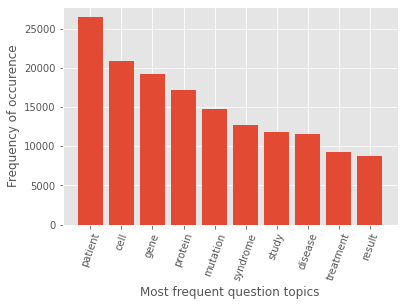

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

plt.bar(range(len(f)), [val[1] for val in f], align='center')
plt.xticks(range(len(f)), [val[0] for val in f])
plt.xticks(rotation=70)
plt.xlabel("Most frequent question topics")
plt.ylabel("Frequency of occurence")
plt.show()

In [ ]:
# Count of occurence of the words 'cancer' and 'pandemic'
cancer=t2.count("cancer")
pandemic = t2.count("pandemic")
print(f"The word cancer is present {cancer} times ")
print(f"The word pandemic is present {pandemic} times ")

The word cancer is present 6097 times 
The word pandemic is present 3 times 


Wordcloud to visualize the most frequently occuring words in the passages

(-0.5, 399.5, 199.5, -0.5)

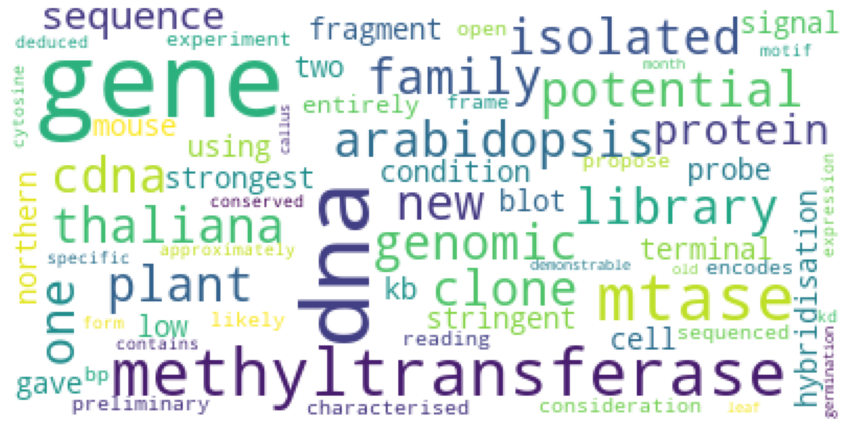

In [ ]:
unique_string = " "
for t in tokens_processed:
     unique_string=(" ").join(t)

wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(unique_string)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)

plt.axis("off")

In [39]:
tokens = []
q = df['question']
p = df["context"]
# print(q[:50])
#for i in range(len(p)):
answers = []
for i in range(len(q)):
    inputs = tokenizer(q[i], p[i], add_special_tokens=True, return_tensors="tf")
    # print(inputs)
    input_ids = inputs["input_ids"].numpy()[0]

    outputs = model(inputs)
    answer_start_scores = outputs.start_logits
    answer_end_scores = outputs.end_logits
    answer_start = tf.argmax(answer_start_scores, axis=1).numpy()[0]  # Get the most likely beginning of answer with the argmax of the score
    answer_end = (tf.argmax(answer_end_scores, axis=1) + 1).numpy()[0]  # Get the most likely end of answer with the argmax of the score
    answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(input_ids[answer_start:answer_end]))
    answers.append(answer)
    print(f"Question: {q[i]}")
    print(f"Answer: {answer}")


Streaming output truncated to the last 5000 lines.
Question: What tyrosine kinase, involved in a Philadelphia- chromosome positive chronic myelogenous leukemia, is the target of Imatinib (Gleevec)?
Answer: abelson murine leukemia
Question: Which proteins participate in the formation of the ryanodine receptor quaternary macromolecular complex?
Answer: junctin, calsequestrin, triadin
Question: For which type of diabetes can empagliflozin be used?
Answer: type 2
Question: List symptoms of the IFAP syndrome.
Answer: ichthyosis follicularis, alopecia and photophobia
Question: Which genes are involved in patient response to warfarin?
Answer: cytochrome p450 ( cyp ) 2c9 ( cyp2c9 ) and vitamin k epoxide reductase complex subunit 1 ( vkorc1 )
Question: What is being measured with an accelerometer in back pain patients
Answer: whole - body acceleration
Question: Which drugs may interfere thyroxine absorption?
Answer: sevelamer hydrochloride and chromium picolinate
Question: Name the major classe

### PERFORMANCE EVALUATION

Using Rouge score to evaluate precision, recall and F-1 score

In [85]:
count = 0
score = 0
for i in range(len(df.answer)):
    try:
        score += nltk.translate.bleu_score.sentence_bleu([df.answer[0].lower().split()],answers[0].split())
        count += 1
    except:
        continue
# scores = score /len(df.answer)
scores = score / count
scores

0.7071067811860148